In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import warnings
df = pd.read_csv('train.csv')
[df['month'],df['day'],df['year']] = [[float(df['id'][i].split('/')[j]) for i in range(df.shape[0])] for j in [0,1,2]]
M = 10
df = df.sort_values(by =['year','month'])

In [93]:
def get(phix,m):     # Returns phi only upto the no. of features 0 to m-1
    newphi = np.copy(phix.T)
    newphi = newphi[0:m]
    return newphi.T

def plot_all(x,hs,xl = 'X',yl = 'Y',legends = [''],xlog = False,scatterFirst = False, ylog = False):      # Plots all curves with x on X and all elements oh hs on Y, ll = xlabel, yl = ylabel, xlog = if x is on logarithmic scale, legends = legends
    plt.figure()
    plt.xlabel(xl)
    plt.ylabel(yl)
    if(xlog):
        plt.xscale('log')
    if(ylog):
        plt.yscale('log')
    if(scatterFirst):
        plt.scatter(x,hs[0],color = 'indigo')
    for h in hs[scatterFirst:]:
        plt.plot(x,h)
    plt.legend(legends)
    plt.show()

def make_batches(phix,tx,bs):                 # Returns the batches of phi,t with batch_size = bs
    N = phix.shape[0]
    newphi = np.copy(phix)
    newphi = np.concatenate((newphi,np.array([tx]).T),axis = 1)
    np.random.shuffle(newphi)
    sz = math.floor(N/bs)
    # print(sz,bs)
    newphi = newphi[0:sz*bs]
    N = phix.shape[0]
    newphi = np.array(np.split(newphi,sz))
    phis = []
    ts = []
    for ph in newphi:
        ts.append(ph.T[-1])
        phis.append((ph.T[0:-1]).T)
    return phis,ts

def MPPI(phi, t, m, lamda):
    phix = get(phi,m)
    wm = (( np.linalg.inv(lamda*np.eye(m) + (phix.T).dot(phix)).dot(phix.T)).dot(t))
    h = phix.dot(wm)
    return wm,h

def SSE(hi,ti):   # Returns Sum of Squares error between the hypothesis h and the target t
    N = hi.shape[0]
    cost = (1/N)*0.5*sum(np.square(hi-ti))
    return cost

def SSG(phii,ti,h,lamda,w):
    N = ti.shape[0]
    gd = np.dot(phii.T,h-ti)/N + lamda*w
    return gd

def batch_gd(phi, alpha, tx, iters, batch_size, m,lamda =0, errorf = SSE, gradient= SSG):
    phix = get(phi,m)
    w = np.ones(m,dtype = 'float')
    M = phix.shape[1]       # Number of features
    N = batch_size          # Number of data points
    for i in range(iters):
        phis,ts = make_batches(phix,tx,batch_size)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                for i in range(len(phis)):
                    phii = phis[i]
                    ti = ts[i]
                    h = phii.dot(w)

                    gd = gradient(phii,ti,h,lamda,w)

                    w = w - (alpha * gd)

                    h = phii.dot(w)
            except RuntimeWarning as e:
                return e
    h = phix.dot(w)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            cost = errorf(h,tx)
        except RuntimeWarning as e:
            return e
    return w,cost,h

def check(phi,t,m):
    N = phi.shape[0]
    batch_sizes =[]
    alphas = []
    for bs in [1,2,5,10,20,50,100]:
        batch_sizes.append(bs)
        alpha,cost = find_alpha(phi,t,bs,1e-5,1,m)
        alphas.append(alpha,cost)
        print(bs,alphas[-1])
    plt.plot(batch_sizes,alphas)

def find_alpha(phi,t,batch_size,l,r,lamda,m,errorf):
    mid = 0
    cost = 0
    for _ in range(5):
        mid = (l+r)/2
        output = batch_gd(phi,mid,t,10000,batch_size,lamda = lamda,m = m)
        if(isinstance(output,RuntimeWarning)):
            r = mid
        elif(output[1] > 1e6):
            r = mid
        else:
            cost = output[1]
            l =mid
    return l,cost

def Cross_Validation(phi,tx,alpha,parts,lamda,m,batch_size = 1,iters=5000,errorf=SSE,gradient=SSG,pinv = True):   # Finds cross validation Error for the given arguments
    # print(m,lamda)
    phix = get(phi,m)
    N = phix.shape[0]
    bs = math.floor(N/parts)
    alls = np.array_split(range(N),parts)
    test_error = 0.0
    training_error = 0.0
    for i in range(parts):
        phii = np.delete(phix,alls[i],axis = 0)
        ti = np.delete(tx,alls[i])
        if(pinv):
            wi,hi = MPPI(phii,ti,m,lamda)   
            costi = SSE(hi,ti)      # Represents the training error
        else:
            wi,costi,hi = batch_gd(phi = phii, alpha = alpha,tx = ti,batch_size= batch_size,lamda = lamda, iters = iters,m = m)
        # Wi and Hi are weights and hypothesis values at all inputs in this training set
        hypothesis_i = phix[alls[i]].dot(wi)    # Represents the hypothesis values at the test set
        training_error += costi # Increment total training error
        test_error += SSE(hypothesis_i,tx[alls[i]]) # Increment total testing error
    test_error /= parts
    training_error /= parts
    test_error = math.sqrt(test_error)
    training_error = math.sqrt(training_error)
    print(test_error,training_error)
    return test_error,training_error

In [90]:
x1 = np.array(df['year'])
x2 = np.array(df['month'])
x1 = np.array([x1[i] - 5 for i in range(len(x1))])
x2 = np.array([x2[i] - 1 for i in range(len(x2))])
t = np.array(df['value'])
x3 = np.array([x1[i]*12 + x2[i] for i in range(x1.shape[0])])
phi = np.array([[pow(xv,i) for i in range(M)] for xv in x3])
months= []
years = []
for j in range(0,12):
    month = []
    for i in range(x1.shape[0]):
        if(x2[i] == j):
            month.append(i)
    months.append(month)

qtrs= []
for j in range(1,5):
    qtr = []
    for i in range(x1.shape[0]):
        if(x2[i] <= j*4 and x2[i] > (j-1)*4):
            qtr.append(i)
    qtrs.append(qtr)

for j in range(0,11):
    qtr = []
    year = []
    for i in range(x1.shape[0]):
        if(x1[i] == j):
            year.append(i)
    years.append(year)
print(phi.shape)

(110, 10)


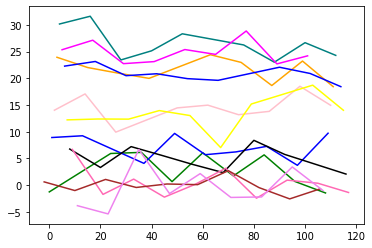

In [81]:
plt.figure()
plt.plot(x3[months[0]],t[months[0]],'green') # 9
plt.plot(x3[months[1]],t[months[1]],'blue') # 7
plt.plot(x3[months[2]],t[months[2]],'pink') # 5
plt.plot(x3[months[3]],t[months[3]],'orange') # 3
plt.plot(x3[months[4]],t[months[4]],'teal') # 1
plt.plot(x3[months[5]],t[months[5]],'magenta') # 2
plt.plot(x3[months[6]],t[months[6]],'blue') # 4
plt.plot(x3[months[7]],t[months[7]],'yellow') # 6
plt.plot(x3[months[8]],t[months[8]],'black') # 8
plt.plot(x3[months[9]],t[months[9]],'hotpink') # 10
plt.plot(x3[months[10]],t[months[10]],'brown') # 12
plt.plot(x3[months[11]],t[months[11]],'violet') # 11
plt.show()

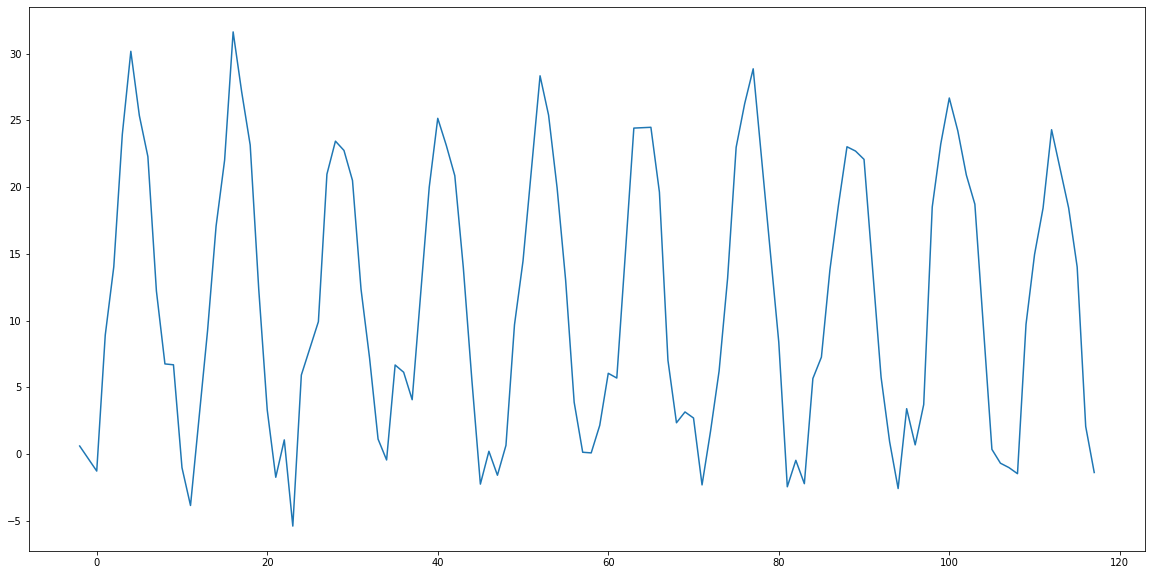

In [61]:
# m3456 = months[3] + months[4] + months[5] + months[6]
# sort(m3456)
plt.figure(figsize=(20,10))
plt.plot(x3,t)

In [ ]:
errors = [Cross_Validation(phi,t, alpha = 1e-4, batch_size = 1, parts = 10, lamda = 0, m = i, pinv = False) for i in range(2,25)]

0.00011536467128984184 7.860164292204728e-05
0.0011217757939991388 0.00017584155161623081
0.0016676018714772485 0.000526492363984865
0.0019615158605358627 0.000609606015088311
0.002118637777404235 0.00047063053418884603
0.002178408299304699 0.0003170190431614475
0.0020710951101167727 0.00021864972918792677
0.001756172987679372 0.00017377684976584056
0.0013409140594449354 0.00018228932447758703
0.0009978078356117008 0.00023032583105424463
0.0009365411422749787 0.0002882613999753426
0.0013582993413671287 0.00032671294698791647
0.0024245407852351137 0.0003299180714012957
0.004235845321972727 0.0003016794663844897
0.006735614873189542 0.00025822816880997554
0.009623331887717421 0.00021816626049767006
0.012344912147092383 0.00019152920339527866
0.014051807752873138 0.00018027537117403425
0.013868975708483892 0.00018425223952352098
0.011182974761066907 0.00019963940288471056
0.006251284401497583 0.00022391373946373613
0.0017130066508954083 0.0002475208625154702
0.004497567133496374 0.0002714

In [91]:
weights = []
hyps = []
for i in range(12):
    weight,hyp = MPPI(phi[months[i]],t[months[i]],8,1e-4)
    # print(i)
    # weight,costi,hyp = batch_gd(phi = phi[months[i]],tx = t[months[i]], m = 3, alpha = 1e-4, lamda = 0, iters= 5000)
    weights.append(weight)
    hyps.append(hyp)
weights = np.array(weights)
hyps = np.array(hyps)

<ipython-input-91-22e1db3e09b8>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hyps = np.array(hyps)


Month :  0
2.437730237739037 2.149878976777167
3.1246510158764043 2.0795235524477103
2.407742398887958 1.5119810179987212
5.173565985497842 1.4557675331991526
4.916223052560638 1.2184588967862169


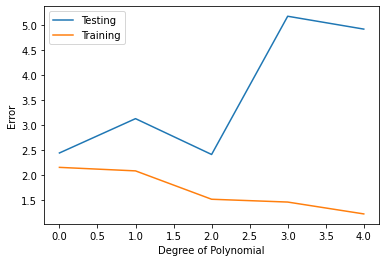

Month :  1
1.7750512488157844 1.5654502307495637
2.0255682568693953 1.4993397774505823
2.180502431994711 1.3514360810319026
2.9010598767072886 1.2964030025052016
5.20143595774514 1.1523054937388388


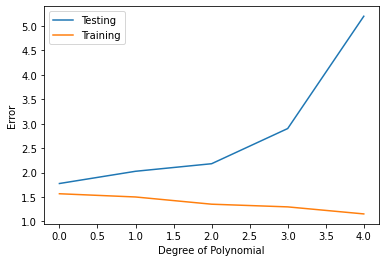

Month :  2
1.8087830475499023 1.5951989231747146
2.012684738516759 1.513933253221019
2.185984656568204 1.4327112851244308
3.0443356443680396 1.3646215676955182
5.0142408281278525 1.2911428860389615


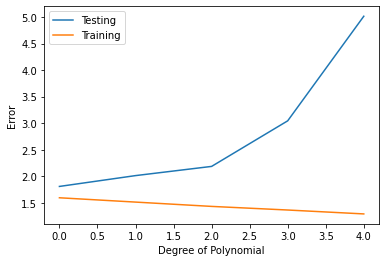

Month :  3
1.6753544829856153 1.477525828128187
1.7704179159127327 1.3678860065878726
2.2369008430062562 1.3304178876723045
1.7629688936731747 1.125890321569141
3.4333710555699155 1.0515557384590368


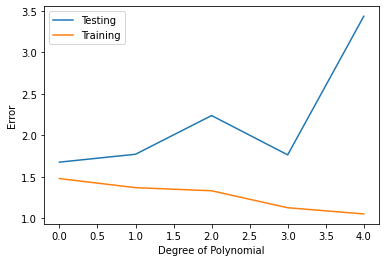

Month :  4
2.239541392477163 1.9750926046939408
2.0596937611907564 1.6012482651625237
2.0949135354172985 1.5029029741882218
2.4135979488692114 1.4288788521170344
5.0362701129325105 1.3458361976131548


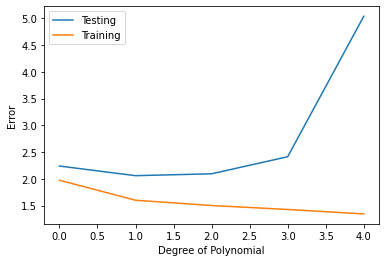

Month :  5
1.5556618482199622 1.3719667009066288
1.7137605920986347 1.3555089616670528
1.8003090000091304 1.3501891338221021
2.6785729987130273 1.1874225106526224
6.569339226735134 1.0755620113777355


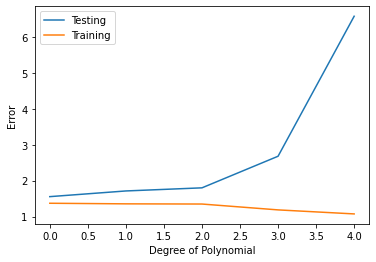

Month :  6
1.0984182559851687 0.9687151962783851
1.0408884102533456 0.7825772904749176
1.3192397941763516 0.7498648065420639
1.8149192133361614 0.588120216214467
1.0034918521794989 0.32326326134431954


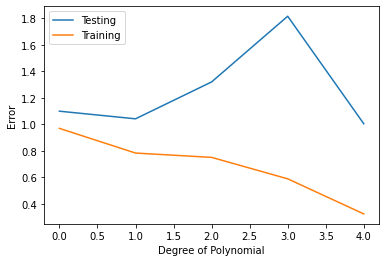

Month :  7
2.313722347188572 2.0405141459277605
2.3131851561175836 1.847154928851573
2.839504925354224 1.7422725569258555
3.9024049481705863 1.7000854474791731
4.490284310454386 1.3700766354000014


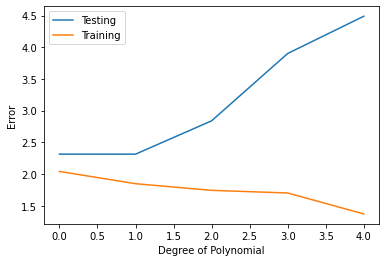

Month :  8
1.6781940808391689 1.480030118922035
1.8519314677183782 1.40255477226282
2.5279776776726077 1.3568613934552969
2.807587910409838 1.238404950389053
4.212844597172262 1.1298480850395456


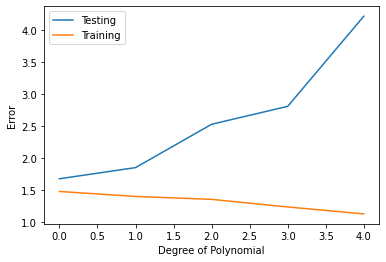

Month :  9
2.091661960683813 1.8708414107075002
2.328116158611694 1.717749643713629
2.895981048132399 1.601598763569913
2.7000577767427285 1.3150523307165631
3.5302062104178105 1.1774156969331178


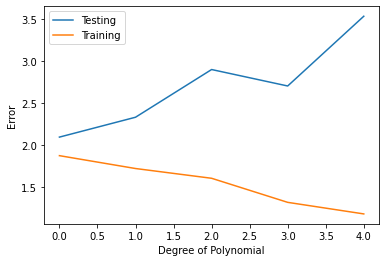

Month :  10
1.0365054855047178 0.9270797199338583
1.0983208989058686 0.8856479495036169
1.2165484824664696 0.820130856687691
1.8303977519379175 0.7798951901154726
2.261288249675326 0.7069171698227859


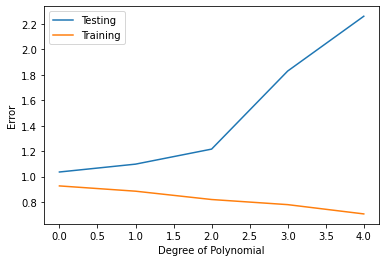

Month :  11
2.862723347603445 2.524688189850429
3.145461555832822 2.4350704629500104
3.0765297409440224 2.3228114970605103
4.581752604993491 2.1384087332933164
10.662049916858185 1.9597476279081099


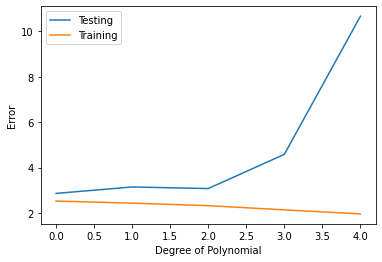

Cumulative Errors


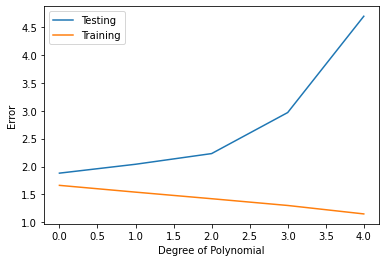

In [111]:
m1 = 6
test_all = np.zeros(m1-1)
train_all = np.zeros(m1-1)
for mt in range(12):
    print('Month : ',mt)
    sz = len(months[mt])
    errors = [Cross_Validation(phi[months[mt]],t[months[mt]], alpha = 1e-4, batch_size = 1, parts = sz, lamda = 1e-4, m = i, pinv = True) for i in range(1,m1)]
    test,train = np.copy(np.array(errors)).T
    plot_all(x = range(m1-1), hs = [test,train],  legends = ['Testing','Training'], xl ='Degree of Polynomial', yl ='Error',)
    test_all += test
    train_all += train
test_all /= 12
train_all /= 12
print("Cumulative Errors")
plot_all(x = range(m1-1), hs = [test_all,train_all],  legends = ['Testing','Training'], xl ='Degree of Polynomial', yl ='Error',)

In [125]:
degrees = [2,2,2,3,2,2,4,2,2,3,2,2]
ms = [deg + 1 for deg in degrees]
ws = []
hys = []
for i in range(12):
    # print("Month: ",i)
    wt,hypt = MPPI(phi[months[i]],t[months[i]],ms[i],1e-4)
    ws.append(wt)
    hy = get(phi[months[i]],ms[i]).dot(wt)
    # plt.figure()
    # plt.scatter(x3[months[i]],t[months[i]])
    # plt.plot(x3[months[i]],hy,'green')
    # plt.show()
    hys.append(hy)

In [126]:
df1 = pd.read_csv('test.csv')
[df1['month'],df1['day'],df1['year']] = [[float(df1['id'][i].split('/')[j]) for i in range(df1.shape[0])] for j in [0,1,2]]
print(weights[0])
for i in range(10):
    mth = int(df1['month'][i]) - 1
    year = int(df1['year'][i]) - 5
    tim = mth + year*12
    phit = np.array([pow(tim,i) for i in range(0,ms[mth])])
    print(df1['id'][i],end= '')
    print(',',end = '')
    print(phit.dot(ws[mth]))

[-1.28338870e+00 -1.96554327e-01  8.32307700e-02 -4.33694742e-03
  9.36228729e-05 -9.77790979e-07  4.81182522e-09 -8.70920591e-12]
5/1/10,25.301661525582315
4/1/09,21.564681218380365
9/1/13,3.919016577690215
1/1/06,1.8956650004058684
2/1/07,7.407486787174719
8/1/12,14.123069869690891
6/1/14,24.659673685696568
3/1/08,13.580911407918265
12/1/04,-5.294098527476766
7/1/11,20.85003328436741
